In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250
C3_IDX = EEG_CHANNELS.index('C3')
C4_IDX = EEG_CHANNELS.index('C4')
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 15

# Simplified Data Loading
def load_trial_data(row, base_path):
    eeg_path = os.path.join(
        base_path,
        row['task'],
        'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test',
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    eeg_data = pd.read_csv(eeg_path)
    samples_per_trial = 2250
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    return eeg_data[EEG_CHANNELS].iloc[start_idx:end_idx].values

# Load metadata
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for MI task
train_df = train_df[(train_df['task'] == 'MI') & (train_df['label'].isin(['Left', 'Right']))]
val_df = val_df[(val_df['task'] == 'MI') & (val_df['label'].isin(['Left', 'Right']))]
test_df = test_df[test_df['task'] == 'MI']

# Map labels
label_map = {'Left': 0, 'Right': 1}
train_df['label'] = train_df['label'].map(label_map)
val_df['label'] = val_df['label'].map(label_map)

# Handle class imbalance
left_df = train_df[train_df['label'] == 0]
right_df = train_df[train_df['label'] == 1]
if len(left_df) < len(right_df):
    left_oversampled = resample(left_df, replace=True, n_samples=len(right_df), random_state=42)
    train_df = pd.concat([right_df, left_oversampled])
elif len(right_df) < len(left_df):
    right_oversampled = resample(right_df, replace=True, n_samples=len(left_df), random_state=42)
    train_df = pd.concat([left_df, right_oversampled])
train_df = train_df.sample(frac=1, random_state=42)

# Simplified Feature Extraction
def extract_basic_features(trial_data):
    """Extract basic time-domain features without filtering"""
    mean_amp = np.mean(trial_data, axis=0)
    std_dev = np.std(trial_data, axis=0)
    variance = np.var(trial_data, axis=0)
    return np.concatenate([
        mean_amp,
        std_dev,
        variance,
        [mean_amp[C3_IDX] - mean_amp[C4_IDX]],
        [variance[C3_IDX] - variance[C4_IDX]]
    ])

# Data Processing
def load_and_process_data(df, eeg_scaler=None, feat_scaler=None, fit_scaler=False):
    eeg_data = []
    features = []
    labels = []
    
    for _, row in df.iterrows():
        trial_eeg = load_trial_data(row, BASE_PATH)
        eeg_data.append(trial_eeg)
        features.append(extract_basic_features(trial_eeg))
        if 'label' in row:
            labels.append(row['label'])
    
    eeg_data = np.array(eeg_data)
    features = np.array(features)
    labels = np.array(labels) if labels else None
    
    # Scale data
    if fit_scaler:
        eeg_scaler = StandardScaler()
        feat_scaler = StandardScaler()
        eeg_data = eeg_scaler.fit_transform(eeg_data.reshape(-1, eeg_data.shape[-1])).reshape(-1, 2250, len(EEG_CHANNELS))
        features = feat_scaler.fit_transform(features)
    else:
        eeg_data = eeg_scaler.transform(eeg_data.reshape(-1, eeg_data.shape[-1])).reshape(-1, 2250, len(EEG_CHANNELS))
        features = feat_scaler.transform(features)
        
    return eeg_data, features, labels, eeg_scaler, feat_scaler

# Process data
print("Processing training data...")
X_train_eeg, X_train_feat, y_train, eeg_scaler, feat_scaler = load_and_process_data(
    train_df, fit_scaler=True
)

print("Processing validation data...")
X_val_eeg, X_val_feat, y_val, _, _ = load_and_process_data(
    val_df, eeg_scaler=eeg_scaler, feat_scaler=feat_scaler
)

print("Processing test data...")
X_test_eeg, X_test_feat, _, _, _ = load_and_process_data(
    test_df, eeg_scaler=eeg_scaler, feat_scaler=feat_scaler
)

# Hemisphere-Specific Model Architecture (unchanged)
def create_hemisphere_model(eeg_shape, feat_shape):
    eeg_input = Input(shape=eeg_shape, name='eeg_input')
    
    # Hemisphere-specific processing
    c3 = layers.Lambda(lambda x: x[:, :, C3_IDX:C3_IDX+1])(eeg_input)
    c4 = layers.Lambda(lambda x: x[:, :, C4_IDX:C4_IDX+1])(eeg_input)
    
    # Shared temporal processing
    def create_temporal_branch():
        return models.Sequential([
            layers.Conv1D(16, 250, activation='relu', padding='same'),
            layers.MaxPooling1D(3),
            layers.Conv1D(32, 50, activation='relu', padding='same'),
            layers.GlobalAveragePooling1D()
        ])
    
    c3_branch = create_temporal_branch()(c3)
    c4_branch = create_temporal_branch()(c4)
    
    # Hemisphere difference features
    diff = layers.Subtract()([c3_branch, c4_branch])
    ratio = layers.Lambda(lambda x: x[0] / (x[1] + 1e-8))([c3_branch, c4_branch])
    
    # Feature branch
    feat_input = Input(shape=(feat_shape,), name='feat_input')
    feat_branch = layers.Dense(64, activation='relu')(feat_input)
    
    # Concatenate all features
    combined = layers.Concatenate()([c3_branch, c4_branch, diff, ratio, feat_branch])
    
    # Classification head
    x = layers.Dense(64, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=[eeg_input, feat_input], outputs=output)

# Create and compile model
model = create_hemisphere_model(
    eeg_shape=(2250, len(EEG_CHANNELS)),
    feat_shape=X_train_feat.shape[1]
)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    [X_train_eeg, X_train_feat], y_train,
    validation_data=([X_val_eeg, X_val_feat], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Generate predictions
test_preds = model.predict([X_test_eeg, X_test_feat])
test_labels = ['Left' if p < 0.5 else 'Right' for p in test_preds]

# Create submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_labels
})
submission.to_csv('submission.csv', index=False)
print("Submission created!")

2025-06-20 04:05:12.894446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750392313.172477      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750392313.254312      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Processing training data...
Processing validation data...
Processing test data...


2025-06-20 04:10:00.625567: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 306ms/step - accuracy: 0.4877 - loss: 222024.6562 - val_accuracy: 0.4800 - val_loss: 0.7096
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - accuracy: 0.5038 - loss: 0.7047 - val_accuracy: 0.4400 - val_loss: 0.6972
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 261ms/step - accuracy: 0.5162 - loss: 0.6967 - val_accuracy: 0.5200 - val_loss: 0.6903
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 260ms/step - accuracy: 0.5246 - loss: 0.6961 - val_accuracy: 0.5200 - val_loss: 0.6909
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.5017 - loss: 0.6917 - val_accuracy: 0.4800 - val_loss: 0.6976
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.5206 - loss: 0.6903 - val_accuracy: 0.5200 - val_loss: 0.7098
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.5254 - loss: 0.6904 - val_accuracy: 0.5200 - val_loss: 0.7075
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - accuracy: 0.5242 - loss: 0.68

KeyboardInterrupt: 

In [3]:
import numpy as np
import pandas as pd
import os
from scipy import signal
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import resample
import pywt  # For wavelet denoising
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling frequency
LOWCUT = 4  # Broadband low cutoff
HIGHCUT = 40  # Broadband high cutoff
C3_IDX = EEG_CHANNELS.index('C3')
C4_IDX = EEG_CHANNELS.index('C4')
BATCH_SIZE = 32
EPOCHS = 200
PATIENCE = 20
LR_PATIENCE = 10
ARTIFACT_THRESHOLD = 150  # Threshold for artifact rejection (μV)
NOISE_STD = 0.1  # Base noise level for augmentation

# Custom callback for F1 score logging
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.f1_scores = []
        
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        f1 = f1_score(self.y_val, y_pred_classes, average='weighted')
        self.f1_scores.append(f1)
        logs['val_f1'] = f1
        print(f' - val_f1: {f1:.4f}')

# Data loading function
def load_trial_data(row, base_path):
    """Load EEG data for a specific trial"""
    # Determine dataset split based on ID
    dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
    
    # Build file path
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    
    # Load EEG data
    eeg_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    samples_per_trial = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    # Extract EEG channels
    trial_data = eeg_data[EEG_CHANNELS].iloc[start_idx:end_idx].values
    return trial_data

# Preprocessing functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Design Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs=FS, order=5):
    """Apply bandpass filter to EEG data"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered[:, i] = signal.filtfilt(b, a, data[:, i])
    return filtered

def apply_robust_filtering(data):
    """Apply notch + bandpass + wavelet denoising"""
    # Notch filter for line noise
    b_notch, a_notch = signal.iirnotch(50, 30, FS)
    filtered = signal.filtfilt(b_notch, a_notch, data, axis=0)
    
    # Bandpass filter
    b, a = butter_bandpass(LOWCUT, HIGHCUT, FS, order=6)
    filtered = signal.filtfilt(b, a, filtered, axis=0)
    
    # Wavelet denoising
    for i in range(filtered.shape[1]):
        coeffs = pywt.wavedec(filtered[:, i], 'db4', level=5)
        # Thresholding
        coeffs[1:] = [pywt.threshold(c, 0.1*np.max(np.abs(c)), 'soft') for c in coeffs[1:]]
        filtered[:, i] = pywt.waverec(coeffs, 'db4')[:len(filtered)]
    
    return filtered

def interpolate_bad_channels(trial):
    """Detect and interpolate bad channels using spatial interpolation"""
    channel_std = np.std(trial, axis=0)
    median_std = np.median(channel_std)
    mad = np.median(np.abs(channel_std - median_std))
    
    bad_channels = np.where(channel_std > median_std + 3 * mad)[0]
    
    # Return early if no bad channels
    if len(bad_channels) == 0:
        return trial
    
    # Create channel positions (simple linear representation)
    channel_positions = np.arange(len(EEG_CHANNELS))
    
    for ch_idx in bad_channels:
        good_channels = [i for i in range(len(EEG_CHANNELS)) if i != ch_idx]
        good_positions = channel_positions[good_channels]
        
        # For each time point, interpolate the bad channel from good channels
        for t in range(trial.shape[0]):
            interp_fn = interp1d(
                good_positions, 
                trial[t, good_channels],
                kind='cubic',
                fill_value="extrapolate"
            )
            trial[t, ch_idx] = interp_fn(channel_positions[ch_idx])
            
    return trial

# Data augmentation
def augment_eeg(eeg, label, noise_std=NOISE_STD, max_shift=100, dropout_prob=0.1):
    """Apply advanced augmentation to EEG data"""
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, eeg.shape)
    augmented = eeg + noise
    
    # Time-shifting
    shift = np.random.randint(-max_shift, max_shift)
    if shift != 0:
        augmented = np.roll(augmented, shift, axis=0)
        if shift > 0:
            augmented[:shift, :] = 0
        else:
            augmented[shift:, :] = 0
    
    # Random channel dropout
    if np.random.rand() < dropout_prob:
        ch_idx = np.random.randint(0, len(EEG_CHANNELS))
        augmented[:, ch_idx] = 0
        
    # Frequency warping
    if np.random.rand() < 0.3:
        scale = np.random.uniform(0.9, 1.1)
        warped = np.zeros_like(augmented)
        for i in range(augmented.shape[1]):
            warped_signal = signal.resample(augmented[:, i], int(len(augmented[:, i]) * scale))
            if len(warped_signal) > len(augmented[:, i]):
                warped[:, i] = warped_signal[:len(augmented[:, i])]
            else:
                warped[:len(warped_signal), i] = warped_signal
        augmented = warped
            
    return augmented

# CNN Model Architecture (5 Conv, 3 FC, 2 Out)
def create_cnn_model(input_shape):
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=input_shape))
    
    # Conv Block 1
    model.add(layers.Conv1D(32, 250, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(32, 250, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(3))
    
    # Conv Block 2
    model.add(layers.Conv1D(64, 100, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(64, 100, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(3))
    
    # Conv Block 3
    model.add(layers.Conv1D(128, 50, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling1D())
    
    # Fully Connected Layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Output Layer
    model.add(layers.Dense(2, activation='softmax'))
    
    return model

# Main execution
if __name__ == "__main__":
    # Load metadata
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Filter for MI task with Left/Right classes
    train_df = train_df[(train_df['task'] == 'MI') & (train_df['label'].isin(['Left', 'Right']))]
    val_df = val_df[(val_df['task'] == 'MI') & (val_df['label'].isin(['Left', 'Right']))]
    test_df = test_df[test_df['task'] == 'MI']
    
    print(f"Filtered training samples: {len(train_df)}")
    print(f"Filtered validation samples: {len(val_df)}")
    print(f"Filtered test samples: {len(test_df)}")
    
    # Map labels to integers
    label_map = {'Left': 0, 'Right': 1}
    train_df['label'] = train_df['label'].map(label_map)
    val_df['label'] = val_df['label'].map(label_map)
    
    # Handle class imbalance by oversampling minority class
    print("\nClass distribution before resampling:")
    print(train_df['label'].value_counts())
    
    # Oversample minority class
    left_df = train_df[train_df['label'] == 0]
    right_df = train_df[train_df['label'] == 1]
    
    if len(left_df) < len(right_df):
        left_oversampled = resample(left_df, replace=True, n_samples=len(right_df), random_state=42)
        train_df = pd.concat([right_df, left_oversampled])
    elif len(right_df) < len(left_df):
        right_oversampled = resample(right_df, replace=True, n_samples=len(left_df), random_state=42)
        train_df = pd.concat([left_df, right_oversampled])
    
    train_df = train_df.sample(frac=1, random_state=42)  # Shuffle
    
    print("\nClass distribution after resampling:")
    print(train_df['label'].value_counts())
    
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=[0,1], y=train_df['label'])
    class_weight_dict = {0: class_weights[0]*1.5, 1: class_weights[1]*0.8}
    print(f"\nClass weights: {class_weight_dict}")
    
    # Load and preprocess data
    def load_and_preprocess_data(df, eeg_scaler=None, fit_scaler=False):
        eeg_data = []
        labels = []
        
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing"):
            # Load raw EEG
            trial_eeg = load_trial_data(row, BASE_PATH)
            
            # Apply robust preprocessing
            trial_eeg = apply_robust_filtering(trial_eeg)
            trial_eeg = interpolate_bad_channels(trial_eeg)
            
            eeg_data.append(trial_eeg)
            if 'label' in row:
                labels.append(row['label'])
        
        eeg_data = np.array(eeg_data)
        labels = np.array(labels) if labels else None
        
        # Scale EEG data
        if fit_scaler:
            eeg_scaler = StandardScaler()
            original_shape = eeg_data.shape
            eeg_data = eeg_data.reshape(-1, original_shape[-1])
            eeg_data = eeg_scaler.fit_transform(eeg_data)
            eeg_data = eeg_data.reshape(original_shape)
        else:
            original_shape = eeg_data.shape
            eeg_data = eeg_data.reshape(-1, original_shape[-1])
            eeg_data = eeg_scaler.transform(eeg_data)
            eeg_data = eeg_data.reshape(original_shape)
            
        return eeg_data, labels, eeg_scaler
    
    print("\nPreprocessing training data...")
    X_train, y_train, eeg_scaler = load_and_preprocess_data(train_df, fit_scaler=True)
    
    print("\nPreprocessing validation data...")
    X_val, y_val, _ = load_and_preprocess_data(val_df, eeg_scaler=eeg_scaler)
    
    print("\nPreprocessing test data...")
    X_test, _, _ = load_and_preprocess_data(test_df, eeg_scaler=eeg_scaler)
    
    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    # Create CNN model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_cnn_model(input_shape)
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    
    # Data generator with augmentation and sample weighting
    def create_data_generator(eeg_data, labels, class_weight_dict, batch_size, augment=False):
        num_samples = len(eeg_data)
        indices = np.arange(num_samples)
        
        while True:
            np.random.shuffle(indices)
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_eeg = eeg_data[batch_indices]
                batch_labels = labels[batch_indices]
                
                if augment:
                    # Apply augmentation
                    batch_eeg = np.array([
                        augment_eeg(e, lbl) for e, lbl in zip(batch_eeg, batch_labels)
                    ])
                
                # Create sample weights based on class weights
                sample_weights = np.array([class_weight_dict[lbl] for lbl in batch_labels])
                
                yield batch_eeg, batch_labels, sample_weights
    
    # Create data generators
    train_gen = create_data_generator(X_train, y_train, class_weight_dict, BATCH_SIZE, augment=True)
    val_gen = create_data_generator(X_val, y_val, {0: 1.0, 1: 1.0}, BATCH_SIZE, augment=False)
    
    # Calculate steps per epoch
    train_steps = int(np.ceil(len(X_train) / BATCH_SIZE))
    val_steps = int(np.ceil(len(X_val) / BATCH_SIZE))
    
    # Callbacks
    f1_callback = F1ScoreCallback(validation_data=(X_val, y_val))
    early_stopping = EarlyStopping(
        monitor='val_f1',
        patience=PATIENCE,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
    checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_f1',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_f1',
        factor=0.5,
        patience=LR_PATIENCE,
        verbose=1,
        mode='max',
        min_lr=1e-6
    )
    
    # Train model
    print("\nTraining model...")
    history = model.fit(
        train_gen,
        steps_per_epoch=train_steps,
        validation_data=val_gen,
        validation_steps=val_steps,
        epochs=EPOCHS,
        callbacks=[f1_callback, early_stopping, checkpoint, lr_scheduler],
        verbose=1
    )
    
    # Save training logs
    training_logs = {
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy'],
        'val_f1': f1_callback.f1_scores
    }
    
    with open('training_logs.pkl', 'wb') as f:
        pickle.dump(training_logs, f)
    print("\nTraining logs saved to 'training_logs.pkl'")
    
    # Plot training history
    plt.figure(figsize=(15, 10))
    
    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(f1_callback.f1_scores, label='Validation F1 Score')
    plt.title('F1 Score Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Learning rate
    if 'lr' in history.history:
        plt.subplot(2, 2, 4)
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()
    
    # Evaluate best model
    best_model = tf.keras.models.load_model('best_model.h5')
    val_pred = best_model.predict(X_val, verbose=0)
    val_pred_classes = np.argmax(val_pred, axis=1)
    
    # Calculate F1 score
    val_f1 = f1_score(y_val, val_pred_classes, average='weighted')
    print(f"\nValidation F1 Score: {val_f1:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val, val_pred_classes, target_names=['Left', 'Right']))
    
    # Confusion matrix
    cm = confusion_matrix(y_val, val_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Left', 'Right'], 
                yticklabels=['Left', 'Right'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    # Generate test predictions
    test_pred = best_model.predict(X_test, verbose=0)
    test_pred_classes = np.argmax(test_pred, axis=1)
    test_labels = ['Left' if p == 0 else 'Right' for p in test_pred_classes]
    
    # Create submission file
    submission = pd.DataFrame({
        'id': test_df['id'],
        'label': test_labels
    })
    submission.to_csv('submission.csv', index=False)
    print("\nSubmission file created!")

Filtered training samples: 2400
Filtered validation samples: 50
Filtered test samples: 50

Class distribution before resampling:
label
1    1213
0    1187
Name: count, dtype: int64

Class distribution after resampling:
label
0    1213
1    1213
Name: count, dtype: int64

Class weights: {0: 1.5, 1: 0.8}

Preprocessing training data...


Preprocessing: 100%|██████████| 2426/2426 [17:33<00:00,  2.30it/s]



Preprocessing validation data...


Preprocessing: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s]



Preprocessing test data...


Preprocessing: 100%|██████████| 50/50 [00:14<00:00,  3.47it/s]



Training data shape: (2426, 2250, 8)
Validation data shape: (50, 2250, 8)
Test data shape: (50, 2250, 8)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 2250, 32)            │          64,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 2250, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 2250, 32)            │         256,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 2250, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 750, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 750, 64)             │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 750, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 750, 64)             │         409,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 750, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 250, 128)            │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 250, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             5

 Total params: 1,413,314 (5.39 MB)

 Trainable params: 1,411,906 (5.39 MB)

 Non-trainable params: 1,408 (5.50 KB)


Training model...
Epoch 1/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4910 - loss: 1.2502 - val_f1: 0.5551

Epoch 1: val_f1 improved from -inf to 0.55508, saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.4909 - loss: 1.2497 - val_accuracy: 0.5800 - val_loss: 0.7268 - val_f1: 0.5551 - learning_rate: 1.0000e-04
Epoch 2/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5085 - loss: 1.1847 - val_f1: 0.4021

Epoch 2: val_f1 did not improve from 0.55508
76/76 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.5083 - loss: 1.1846 - val_accuracy: 0.5600 - val_loss: 1.1107 - val_f1: 0.4021 - learning_rate: 1.0000e-04
Epoch 3/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5027 - loss: 1.1098 - val_f1: 0.4736

Epoch 3: val_f1 did not improve from 0.55508
76/76 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.5027 - loss: 1.1097 - val_accuracy: 0.5800 - val_loss: 0.7950 - val_f1: 0.4736 - learning_rate: 1.0000e-04
Epoch 4/200
15/76 ━━━━━━━

KeyboardInterrupt: 

Original training samples: 4800
Original validation samples: 100
Original test samples: 100

Filtered training samples: 2400
Filtered validation samples: 50
Filtered test samples: 50

Class distribution before resampling:
label
1    1213
0    1187
Name: count, dtype: int64

Class distribution after resampling:
label
0    1213
1    1213
Name: count, dtype: int64

Test data loaded - Shape: (2250, 8), Label: 0

Class weights: {0: 1.5, 1: 0.8}

Plotting typical trials for diagnostic purposes...


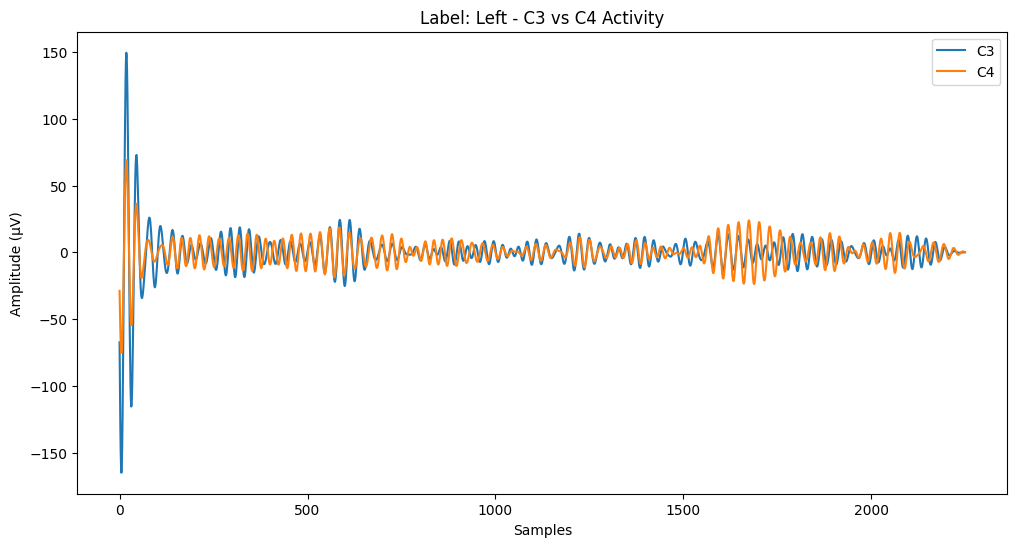

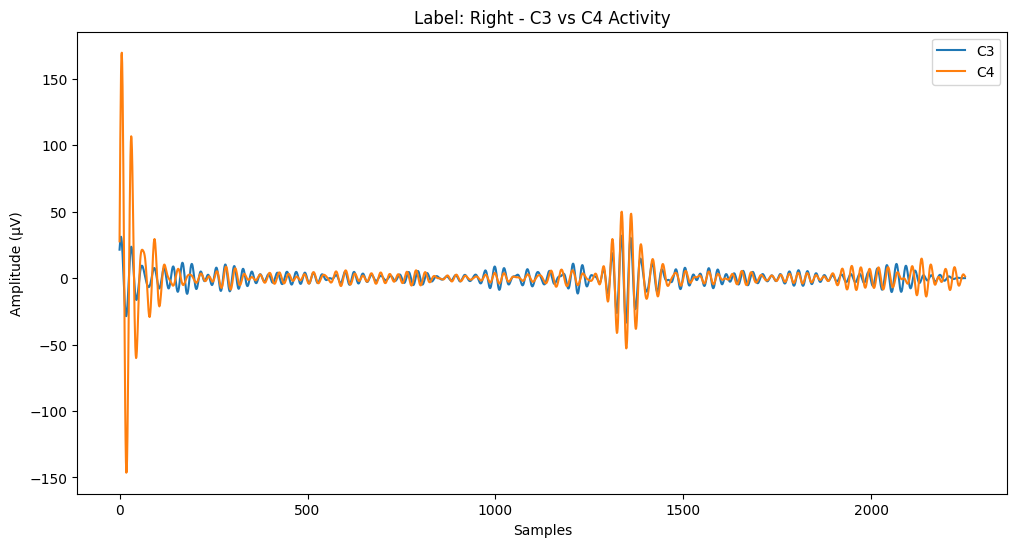


Verifying contralateral patterns (diagnostic only)...
Training: 1195/2426 valid trials (49.3%)
Validation: 32/50 valid trials (64.0%)

Using ALL trials for training and validation, including those without clear contralateral patterns
Preparing CSP training data...


100%|██████████| 2426/2426 [17:40<00:00,  2.29it/s]


CSP input shapes - Mu: (2426, 8, 2250), Beta: (2426, 8, 2250)
Label shape: (2426,)
Training CSP filters...
Computing rank from data with rank=None
    Using tolerance 2.5e+03 (2.2e-16 eps * 8 dim * 1.4e+18  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3e+03 (2.2e-16 eps * 8 dim * 1.7e+18  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Adding positions for missing channels: {'FZ', 'OZ', 'PZ', 'CZ'}


/tmp/ipykernel_35/4048100979.py:361: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(custom_montage)
/tmp/ipykernel_35/4048100979.py:368: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N_COMPONENTS, i+1)
/tmp/ipykernel_35/4048100979.py:368: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N_COMPONENTS, i+1)
/tmp/ipykernel_35/4048100979.py:368: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N_COMPONENTS, i+1)
/tmp/ipykernel_35/4048100979.py:371: UserWarning: The figure layout has changed to tight
  plt.

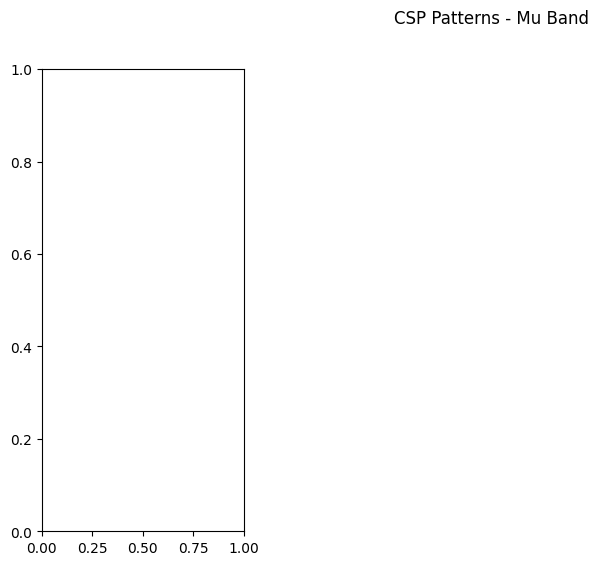

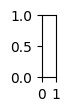

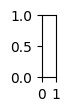

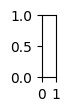

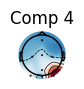

Processing training data...


100%|██████████| 2426/2426 [18:02<00:00,  2.24it/s]



Processing validation data...


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]



Processing test data...


100%|██████████| 50/50 [00:15<00:00,  3.27it/s]



Training EEG shape: (2426, 2250, 8), Feature shape: (2426, 98)
Validation EEG shape: (50, 2250, 8), Feature shape: (50, 98)
Test EEG shape: (50, 2250, 8), Feature shape: (50, 98)


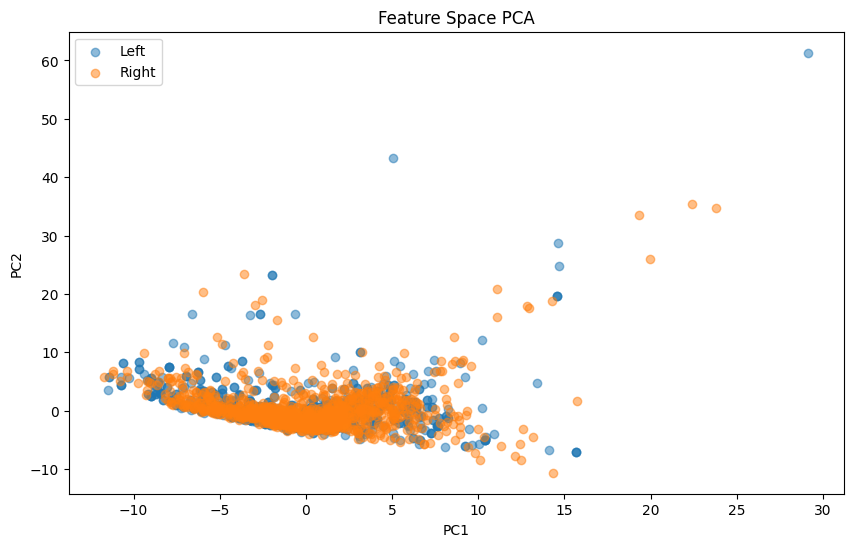

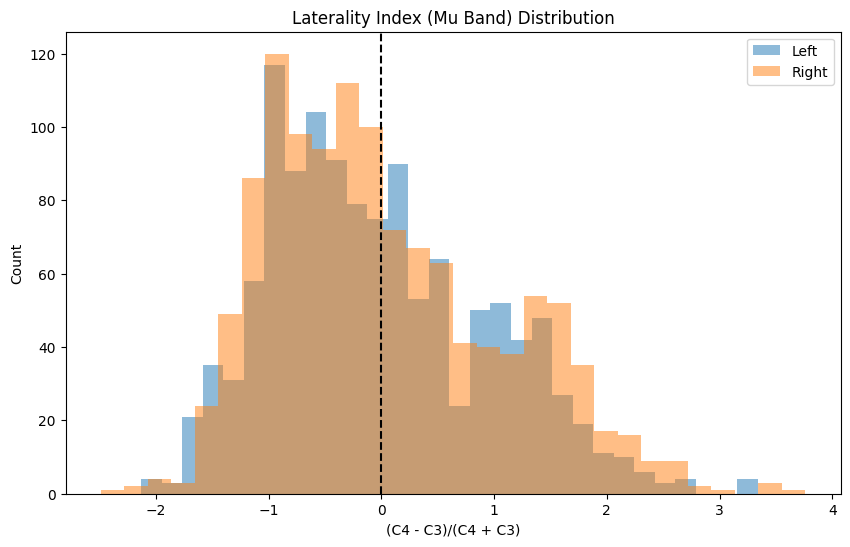


Plotting noisy training samples...
Found 1 potentially noisy samples


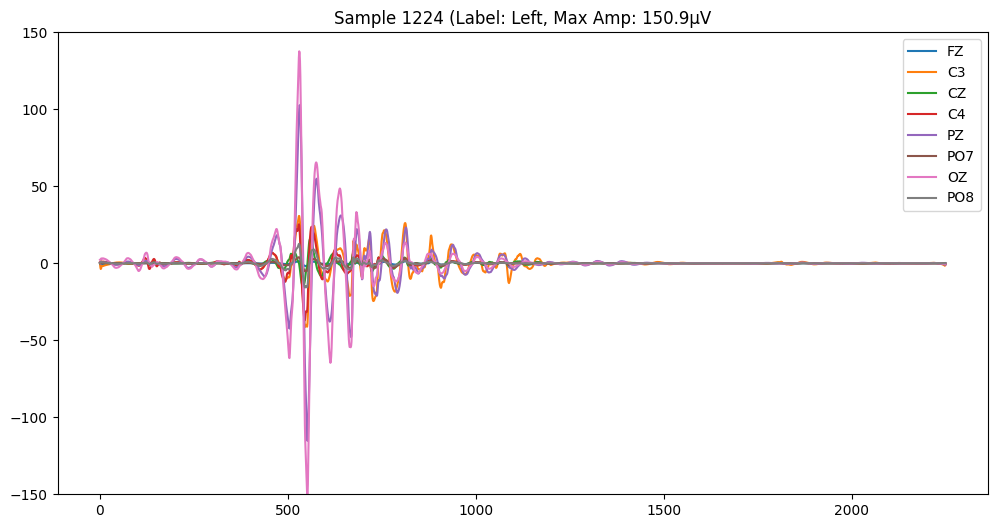

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ eeg_input (InputLayer)    │ (None, 2250, 8)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 2250, 1)        │              0 │ eeg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 2250, 1)        │              0 │ eeg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 32)             │         29,648 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 32)             │         29,648 │ lambda_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feat_input (InputLayer)   │ (None, 98)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_1 (Subtract)     │ (None, 32)             │              0 │ sequential_4[0][0],    │
│                           │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 32)             │              0 │ sequential_4[0][0],    │
│                           │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          6,336 │ feat_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 192)            │              0 │ sequential_4[0][0],    │
│ (Concatenate)             │                        │                │ sequential_5[0][0],    │
│                           │                        │                │ subtract_1[0][0],      │
│                           │                        │                │ lambda_5[0][0],        │
│                           │                        │                │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │         12,352 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             65 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 78,049 (304.88 KB)

 Trainable params: 78,049 (304.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5078 - f1_metric: 0.4726 - loss: 2014.7596
Epoch 1: val_f1_metric improved from -inf to 0.46101, saving model to best_model.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 26s 274ms/step - accuracy: 0.5078 - f1_metric: 0.4721 - loss: 2036.8960 - val_accuracy: 0.5600 - val_f1_metric: 0.4610 - val_loss: 0.7466 - learning_rate: 1.0000e-04
Epoch 2/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5248 - f1_metric: 0.3015 - loss: 1991.1034
Epoch 2: val_f1_metric did not improve from 0.46101
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - accuracy: 0.5248 - f1_metric: 0.3012 - loss: 2007.4624 - val_accuracy: 0.5800 - val_f1_metric: 0.3034 - val_loss: 0.7163 - learning_rate: 1.0000e-04
Epoch 3/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5514 - f1_metric: 0.2922 - loss: 2224.8503
Epoch 3: val_f1_metric did not improve from 0.46101
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 272ms/step - accuracy: 0.5512 - f1_metric: 0.2920 - loss: 2232.54

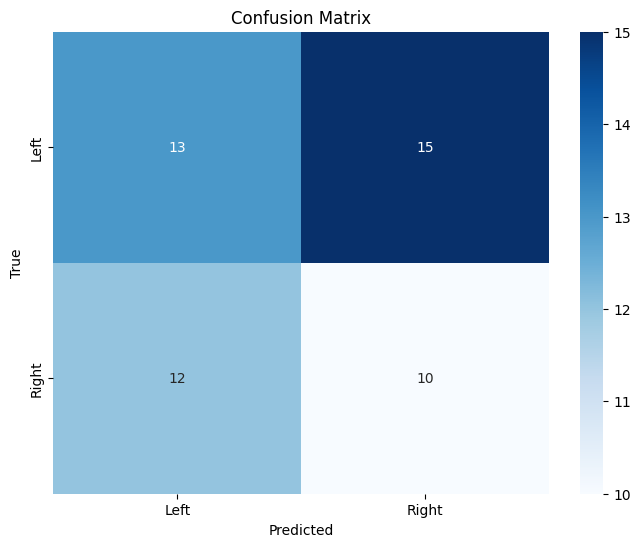


Optimal Decision Threshold: 0.3163 (F1: 0.5769)

Optimized Classification Report:
              precision    recall  f1-score   support

        Left       0.65      0.46      0.54        28
       Right       0.50      0.68      0.58        22

    accuracy                           0.56        50
   macro avg       0.57      0.57      0.56        50
weighted avg       0.58      0.56      0.56        50



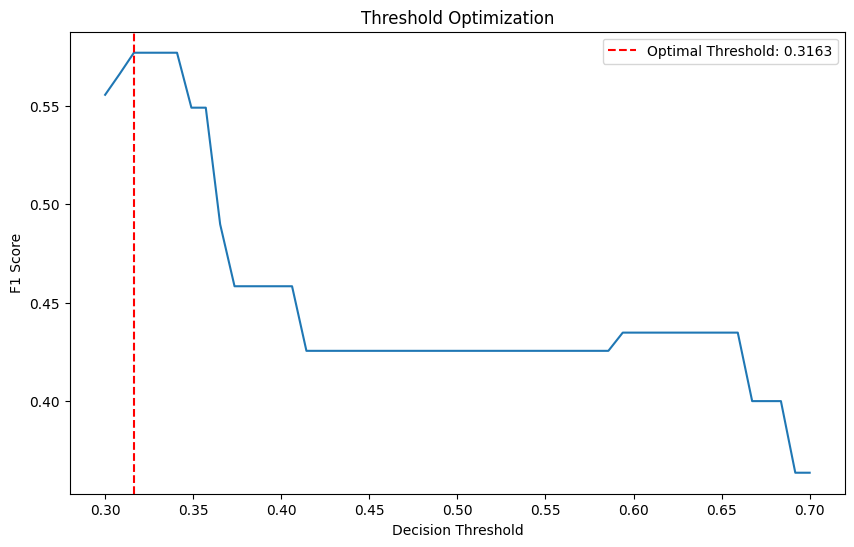


Feature Importance Analysis:


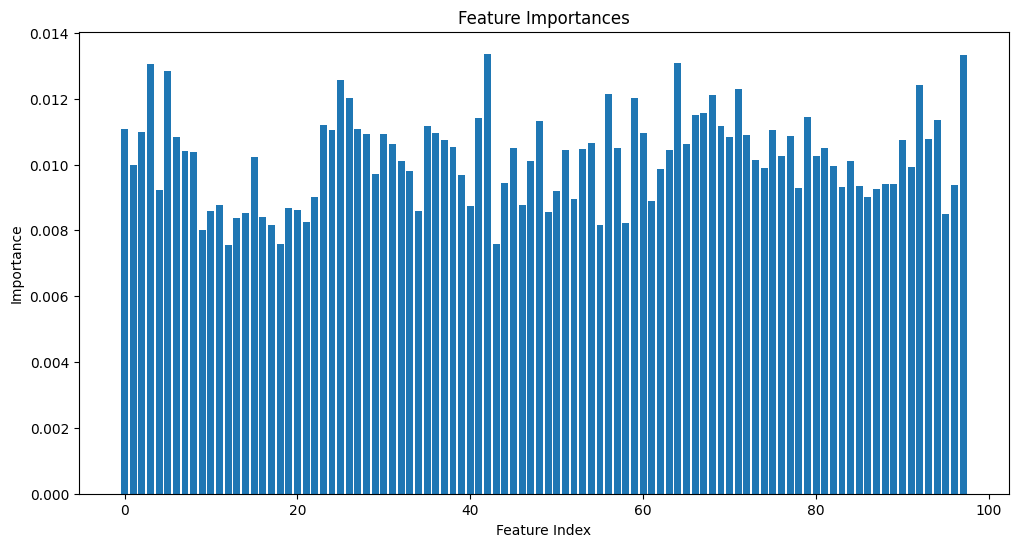

Top 10 features: [42 97 64  3  5 25 92 71 56 68]

Analyzing 27 misclassified samples...


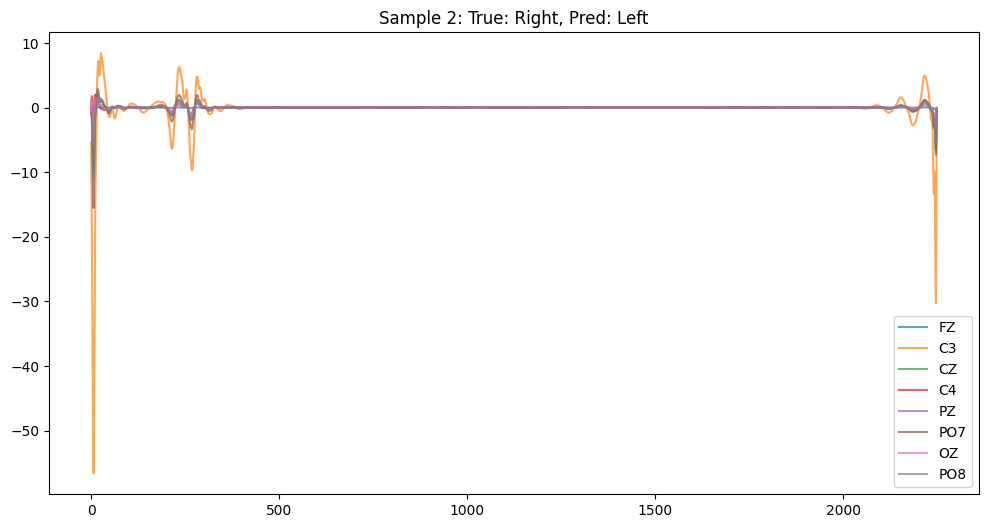

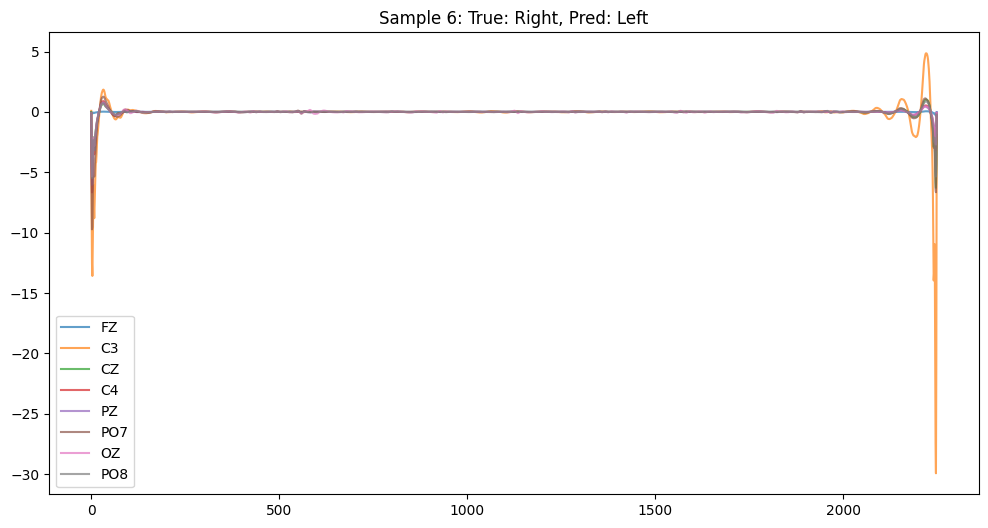

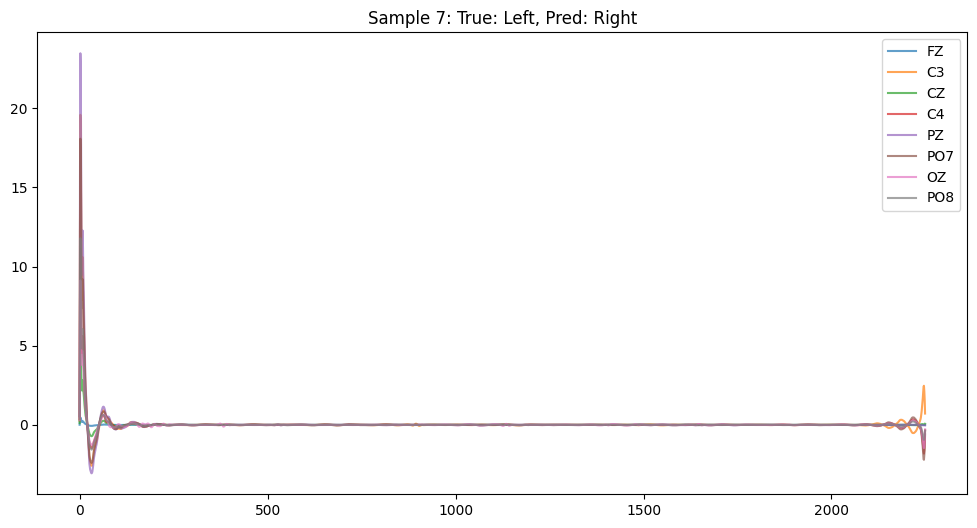

Submission file created!


In [8]:
# %% [markdown]
# # Advanced Hybrid CNN + Logistic Regression for Motor Imagery Classification
# 
# This notebook implements an advanced hybrid model with:
# - Neurophysiological pattern verification (diagnostic only)
# - Enhanced lateralization features
# - Data inspection and diagnostics
# - Hemisphere-specific modeling
# - Improved data augmentation
# - Comprehensive evaluation

# %% [code]
import numpy as np
import pandas as pd
import os
import mne
from mne.decoding import CSP
from scipy import signal
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import resample
import pywt  # For wavelet denoising

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# %% [markdown]
# ## Configuration

# %% [code]
# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling frequency
LOWCUT = 4  # Broadband low cutoff
HIGHCUT = 40  # Broadband high cutoff
MU_BAND = (8, 12)  # Mu band range
BETA_BAND = (12, 30)  # Beta band range
C3_IDX = EEG_CHANNELS.index('C3')
C4_IDX = EEG_CHANNELS.index('C4')
N_COMPONENTS = 4  # CSP components
BATCH_SIZE = 32
EPOCHS = 200
PATIENCE = 20
LR_PATIENCE = 10
SWA_START_EPOCH = 150  # Start SWA at 75% of training
ARTIFACT_THRESHOLD = 150  # Threshold for artifact rejection (μV)
NOISE_STD = 0.1  # Base noise level for augmentation

# %% [markdown]
# ## Data Loading & Preprocessing

# %% [code]
def load_trial_data(row, base_path):
    """Load EEG data for a specific trial"""
    # Determine dataset split based on ID
    dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
    
    # Build file path
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    
    # Load EEG data
    eeg_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    samples_per_trial = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    # Extract EEG channels
    trial_data = eeg_data[EEG_CHANNELS].iloc[start_idx:end_idx].values
    return trial_data

# %% [code]
# Load metadata
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Print dataset statistics
print(f"Original training samples: {len(train_df)}")
print(f"Original validation samples: {len(val_df)}")
print(f"Original test samples: {len(test_df)}")

# Filter for MI task with Left/Right classes
train_df = train_df[(train_df['task'] == 'MI') & (train_df['label'].isin(['Left', 'Right']))]
val_df = val_df[(val_df['task'] == 'MI') & (val_df['label'].isin(['Left', 'Right']))]
test_df = test_df[test_df['task'] == 'MI']

print(f"\nFiltered training samples: {len(train_df)}")
print(f"Filtered validation samples: {len(val_df)}")
print(f"Filtered test samples: {len(test_df)}")

# Check for empty datasets
if len(train_df) == 0:
    raise ValueError("No training samples found after filtering! Check label names.")
if len(val_df) == 0:
    raise ValueError("No validation samples found after filtering! Check label names.")

# Map labels to integers
label_map = {'Left': 0, 'Right': 1}
train_df['label'] = train_df['label'].map(label_map)
val_df['label'] = val_df['label'].map(label_map)

# Handle class imbalance by oversampling minority class
print("\nClass distribution before resampling:")
print(train_df['label'].value_counts())

# Oversample minority class
left_df = train_df[train_df['label'] == 0]
right_df = train_df[train_df['label'] == 1]

# Resample to match majority class count
if len(left_df) < len(right_df):
    left_oversampled = resample(left_df, replace=True, n_samples=len(right_df), random_state=42)
    train_df = pd.concat([right_df, left_oversampled])
elif len(right_df) < len(left_df):
    right_oversampled = resample(right_df, replace=True, n_samples=len(left_df), random_state=42)
    train_df = pd.concat([left_df, right_oversampled])

train_df = train_df.sample(frac=1, random_state=42)  # Shuffle

print("\nClass distribution after resampling:")
print(train_df['label'].value_counts())

# Test data loading with first sample
test_row = train_df.iloc[0]
test_data = load_trial_data(test_row, BASE_PATH)
print(f"\nTest data loaded - Shape: {test_data.shape}, Label: {test_row['label']}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=[0,1], y=train_df['label'])
class_weight_dict = {0: class_weights[0]*1.5, 1: class_weights[1]*0.8}  # Aggressive weighting for minority class
print(f"\nClass weights: {class_weight_dict}")

# %% [markdown]
# ## Neurophysiological Pattern Verification (Diagnostic Only)

# %% [code]
def plot_typical_trial(df, label, base_path):
    """Plot C3 vs C4 for a typical trial of given label"""
    label_trials = df[df['label'] == label]
    if len(label_trials) == 0:
        print(f"No trials found for label {label}")
        return
        
    row = label_trials.iloc[0]
    trial_data = load_trial_data(row, base_path)
    
    # Apply mu filter
    mu_filtered = apply_filter(trial_data, *MU_BAND)
    
    plt.figure(figsize=(12, 6))
    plt.plot(mu_filtered[:, C3_IDX], label='C3')
    plt.plot(mu_filtered[:, C4_IDX], label='C4')
    plt.title(f"Label: {'Left' if label==0 else 'Right'} - C3 vs C4 Activity")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (μV)")
    plt.legend()
    plt.savefig(f'c3_c4_comparison_{"Left" if label==0 else "Right"}.png')
    plt.show()

# Modify the verify_contralateral function to be less strict
def verify_contralateral(row, base_path):
    """Verify if trial shows expected contralateral pattern with relaxed criteria"""
    trial_data = load_trial_data(row, base_path)
    mu_filtered = apply_filter(trial_data, *MU_BAND)
    
    # Calculate power in mu band
    power_c3 = np.var(mu_filtered[:, C3_IDX])
    power_c4 = np.var(mu_filtered[:, C4_IDX])
    
    if row['label'] == 0:  # Left imagery - should have lower power in C4 (right hemisphere)
        # Relaxed criteria: only require C4 < C3 (no percentage threshold)
        return power_c4 < power_c3
    else:  # Right imagery - should have lower power in C3 (left hemisphere)
        return power_c3 < power_c4

# Plot typical trials
print("\nPlotting typical trials for diagnostic purposes...")
plot_typical_trial(train_df, 0, BASE_PATH)  # Left
plot_typical_trial(train_df, 1, BASE_PATH)  # Right

# Verify contralateral patterns (for diagnostics only)
print("\nVerifying contralateral patterns (diagnostic only)...")
train_df['valid'] = train_df.apply(verify_contralateral, axis=1, base_path=BASE_PATH)
val_df['valid'] = val_df.apply(verify_contralateral, axis=1, base_path=BASE_PATH)

print(f"Training: {len(train_df[train_df['valid']])}/{len(train_df)} valid trials ({len(train_df[train_df['valid']])/len(train_df)*100:.1f}%)")
print(f"Validation: {len(val_df[val_df['valid']])}/{len(val_df)} valid trials ({len(val_df[val_df['valid']])/len(val_df)*100:.1f}%)")

# We do NOT drop invalid trials - use all data
print("\nUsing ALL trials for training and validation, including those without clear contralateral patterns")

# %% [markdown]
# ## Advanced Feature Engineering & CSP Setup

# %% [code]
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Design Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs=FS, order=5):
    """Apply bandpass filter to EEG data"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered[:, i] = signal.filtfilt(b, a, data[:, i])
    return filtered

def apply_robust_filtering(data):
    """Apply notch + bandpass + wavelet denoising"""
    # Notch filter for line noise
    b_notch, a_notch = signal.iirnotch(50, 30, FS)
    filtered = signal.filtfilt(b_notch, a_notch, data, axis=0)
    
    # Bandpass filter
    b, a = butter_bandpass(LOWCUT, HIGHCUT, FS, order=6)
    filtered = signal.filtfilt(b, a, filtered, axis=0)
    
    # Wavelet denoising
    for i in range(filtered.shape[1]):
        coeffs = pywt.wavedec(filtered[:, i], 'db4', level=5)
        # Thresholding
        coeffs[1:] = [pywt.threshold(c, 0.1*np.max(np.abs(c)), 'soft') for c in coeffs[1:]]
        filtered[:, i] = pywt.waverec(coeffs, 'db4')[:len(filtered)]
    
    return filtered

def interpolate_bad_channels(trial):
    """Detect and interpolate bad channels using spatial interpolation"""
    channel_std = np.std(trial, axis=0)
    median_std = np.median(channel_std)
    mad = np.median(np.abs(channel_std - median_std))
    
    bad_channels = np.where(channel_std > median_std + 3 * mad)[0]
    
    # Return early if no bad channels
    if len(bad_channels) == 0:
        return trial
    
    # Create channel positions (simple linear representation)
    channel_positions = np.arange(len(EEG_CHANNELS))
    
    for ch_idx in bad_channels:
        good_channels = [i for i in range(len(EEG_CHANNELS)) if i != ch_idx]
        good_positions = channel_positions[good_channels]
        
        # For each time point, interpolate the bad channel from good channels
        for t in range(trial.shape[0]):
            interp_fn = interp1d(
                good_positions, 
                trial[t, good_channels],
                kind='cubic',
                fill_value="extrapolate"
            )
            trial[t, ch_idx] = interp_fn(channel_positions[ch_idx])
            
    return trial

# Hjorth parameters calculation
def hjorth_params(signal_data):
    """Calculate Hjorth parameters: Activity, Mobility, Complexity"""
    activity = np.var(signal_data)
    diff1 = np.diff(signal_data)
    mobility = np.std(diff1) / (np.std(signal_data) + 1e-8)
    diff2 = np.diff(diff1)
    complexity = (np.std(diff2) / (np.std(diff1) + 1e-8)) / (mobility + 1e-8)
    return activity, mobility, complexity

# %% [code]
# Prepare training data for CSP
print("Preparing CSP training data...")
train_trials_mu = []
train_trials_beta = []
train_labels = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    trial_data = load_trial_data(row, BASE_PATH)
    
    # Apply robust filtering and interpolation
    trial_data = apply_robust_filtering(trial_data)
    trial_data = interpolate_bad_channels(trial_data)
    
    # Apply filters
    mu_filtered = apply_filter(trial_data, *MU_BAND)
    beta_filtered = apply_filter(trial_data, *BETA_BAND)
    
    # Transpose to (channels, time)
    train_trials_mu.append(mu_filtered.T)
    train_trials_beta.append(beta_filtered.T)
    train_labels.append(row['label'])

# Convert to arrays
train_trials_mu = np.array(train_trials_mu)
train_trials_beta = np.array(train_trials_beta)
train_labels = np.array(train_labels)

print(f"CSP input shapes - Mu: {train_trials_mu.shape}, Beta: {train_trials_beta.shape}")
print(f"Label shape: {train_labels.shape}")

# Train CSP filters
print("Training CSP filters...")
csp_mu = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)
csp_beta = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)

csp_mu.fit(train_trials_mu, train_labels)
csp_beta.fit(train_trials_beta, train_labels)

# Create Info object for visualization
info = mne.create_info(ch_names=EEG_CHANNELS, sfreq=FS, ch_types='eeg')

# Use the standard_1005 montage which has more channels
montage = mne.channels.make_standard_montage('standard_1005')

# Only use the positions for our specific channels
ch_pos = {ch: montage.get_positions()['ch_pos'][ch] 
          for ch in EEG_CHANNELS if ch in montage.ch_names}

# Add positions for any missing channels
missing_chans = set(EEG_CHANNELS) - set(ch_pos.keys())
if missing_chans:
    print(f"Adding positions for missing channels: {missing_chans}")
    # Use approximate positions for missing channels
    approx_positions = {
        'FZ': [0, 0.07, 0],
        'CZ': [0, 0, 0],
        'PZ': [0, -0.07, 0],
        'OZ': [0, -0.1, 0]
    }
    for ch in missing_chans:
        if ch in approx_positions:
            ch_pos[ch] = np.array(approx_positions[ch])

# Create custom montage
custom_montage = mne.channels.make_dig_montage(ch_pos=ch_pos)
info.set_montage(custom_montage)

# Plot CSP patterns
csp_patterns_mu = csp_mu.patterns_.T
plt.figure(figsize=(12, 6))
plt.suptitle('CSP Patterns - Mu Band')
for i in range(N_COMPONENTS):
    plt.subplot(1, N_COMPONENTS, i+1)
    mne.viz.plot_topomap(csp_patterns_mu[i], info, show=False)
    plt.title(f'Comp {i+1}')
plt.tight_layout()
plt.savefig('csp_patterns_mu.png')
plt.show()

# %% [code]
def extract_improved_features(trial_data):
    """Extract advanced handcrafted features with enhanced lateralization"""
    # Time-domain features
    mean_amp = np.mean(trial_data, axis=0)
    rms = np.sqrt(np.mean(trial_data**2, axis=0))
    var = np.var(trial_data, axis=0)
    skewness = skew(trial_data, axis=0)
    kurt = kurtosis(trial_data, axis=0)
    
    # Hjorth parameters for each channel
    hjorth_features = []
    for i in range(trial_data.shape[1]):
        activity, mobility, complexity = hjorth_params(trial_data[:, i])
        hjorth_features.extend([activity, mobility, complexity])
    hjorth_features = np.array(hjorth_features)
    
    # Frequency-domain features
    broadband = apply_filter(trial_data, LOWCUT, HIGHCUT)
    mu_band = apply_filter(trial_data, *MU_BAND)
    beta_band = apply_filter(trial_data, *BETA_BAND)
    
    # Power calculations
    power_broad = np.var(broadband, axis=0)
    power_mu = np.var(mu_band, axis=0) / (power_broad + 1e-8)
    power_beta = np.var(beta_band, axis=0) / (power_broad + 1e-8)
    
    # Power differences and asymmetry ratios
    diff_mu = power_mu[C3_IDX] - power_mu[C4_IDX]
    diff_beta = power_beta[C3_IDX] - power_beta[C4_IDX]
    asymmetry_mu = (power_mu[C3_IDX] - power_mu[C4_IDX]) / (power_mu[C3_IDX] + power_mu[C4_IDX] + 1e-8)
    asymmetry_beta = (power_beta[C3_IDX] - power_beta[C4_IDX]) / (power_beta[C3_IDX] + power_beta[C4_IDX] + 1e-8)
    
    # Enhanced lateralization features
    contra_ipsi_mu = []
    contra_ipsi_beta = []
    
    # For left hand: contralateral is C4, ipsilateral is C3
    # For right hand: contralateral is C3, ipsilateral is C4
    ratio_mu_left = power_mu[C4_IDX] / (power_mu[C3_IDX] + 1e-8)
    ratio_beta_left = power_beta[C4_IDX] / (power_beta[C3_IDX] + 1e-8)
    ratio_mu_right = power_mu[C3_IDX] / (power_mu[C4_IDX] + 1e-8)
    ratio_beta_right = power_beta[C3_IDX] / (power_beta[C4_IDX] + 1e-8)
    
    laterality_mu = (power_mu[C4_IDX] - power_mu[C3_IDX]) / (power_mu[C4_IDX] + power_mu[C3_IDX] + 1e-8)
    laterality_beta = (power_beta[C4_IDX] - power_beta[C3_IDX]) / (power_beta[C4_IDX] + power_beta[C3_IDX] + 1e-8)
    
    # CSP features
    csp_features_mu = csp_mu.transform(mu_band.T[np.newaxis, :, :])
    csp_features_beta = csp_beta.transform(beta_band.T[np.newaxis, :, :])
    
    # Combine all features
    return np.concatenate([
        mean_amp,
        rms,
        var,
        skewness,
        kurt,
        hjorth_features,
        power_mu,
        power_beta,
        [diff_mu, diff_beta, asymmetry_mu, asymmetry_beta],
        [ratio_mu_left, ratio_beta_left, ratio_mu_right, ratio_beta_right],
        [laterality_mu, laterality_beta],
        csp_features_mu.flatten(),
        csp_features_beta.flatten()
    ])

# %% [code]
def load_and_process_data(df, scaler=None, fit_scaler=False):
    """Load and process dataset with feature extraction"""
    eeg_data = []
    features = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Load raw EEG
        trial_eeg = load_trial_data(row, BASE_PATH)
        
        # Apply robust preprocessing
        trial_eeg = apply_robust_filtering(trial_eeg)
        trial_eeg = interpolate_bad_channels(trial_eeg)
        
        eeg_data.append(trial_eeg)
        
        # Extract features
        trial_features = extract_improved_features(trial_eeg)
        features.append(trial_features)
        
        # Get label if available
        if 'label' in row:
            labels.append(row['label'])
    
    # Convert to arrays
    eeg_data = np.array(eeg_data)
    features = np.array(features)
    labels = np.array(labels) if labels else None
    
    # Scale features
    if fit_scaler:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
        
    return eeg_data, features, labels, scaler

# %% [code]
print("Processing training data...")
X_train_eeg, X_train_feat, y_train, feat_scaler = load_and_process_data(
    train_df, fit_scaler=True
)

print("\nProcessing validation data...")
X_val_eeg, X_val_feat, y_val, _ = load_and_process_data(
    val_df, scaler=feat_scaler
)

print("\nProcessing test data...")
X_test_eeg, X_test_feat, _, _ = load_and_process_data(
    test_df, scaler=feat_scaler
)

# Scale EEG data (per channel)
eeg_scaler = StandardScaler()
X_train_eeg = eeg_scaler.fit_transform(X_train_eeg.reshape(-1, X_train_eeg.shape[-1]))
X_train_eeg = X_train_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_val_eeg = eeg_scaler.transform(X_val_eeg.reshape(-1, X_val_eeg.shape[-1]))
X_val_eeg = X_val_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

X_test_eeg = eeg_scaler.transform(X_test_eeg.reshape(-1, X_test_eeg.shape[-1]))
X_test_eeg = X_test_eeg.reshape(-1, 2250, len(EEG_CHANNELS))

print(f"\nTraining EEG shape: {X_train_eeg.shape}, Feature shape: {X_train_feat.shape}")
print(f"Validation EEG shape: {X_val_eeg.shape}, Feature shape: {X_val_feat.shape}")
print(f"Test EEG shape: {X_test_eeg.shape}, Feature shape: {X_test_feat.shape}")

# %% [markdown]
# ## Data Inspection & Diagnostics

# %% [code]
# Plot feature space
pca = PCA(n_components=2)
feat_pca = pca.fit_transform(X_train_feat)

plt.figure(figsize=(10, 6))
plt.scatter(feat_pca[y_train==0, 0], feat_pca[y_train==0, 1], alpha=0.5, label='Left')
plt.scatter(feat_pca[y_train==1, 0], feat_pca[y_train==1, 1], alpha=0.5, label='Right')
plt.title('Feature Space PCA')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.savefig('feature_pca.png')
plt.show()

# Plot asymmetry distribution
plt.figure(figsize=(10, 6))
plt.hist(X_train_feat[y_train == 0, -6], bins=30, alpha=0.5, label='Left')  # Laterality_mu
plt.hist(X_train_feat[y_train == 1, -6], bins=30, alpha=0.5, label='Right')
plt.axvline(0, color='k', linestyle='--')
plt.title("Laterality Index (Mu Band) Distribution")
plt.xlabel("(C4 - C3)/(C4 + C3)")
plt.ylabel("Count")
plt.legend()
plt.savefig('laterality_distribution.png')
plt.show()

# Plot noisy samples
def plot_noisy_samples(eeg_data, labels, threshold=100):
    max_amps = np.max(np.abs(eeg_data), axis=(1, 2))
    noisy_idx = np.where(max_amps > threshold)[0]
    
    print(f"Found {len(noisy_idx)} potentially noisy samples")
    
    for idx in noisy_idx[:3]:
        plt.figure(figsize=(12, 6))
        for ch in range(eeg_data.shape[2]):
            plt.plot(eeg_data[idx, :, ch], label=EEG_CHANNELS[ch])
        plt.title(f"Sample {idx} (Label: {'Left' if labels[idx]==0 else 'Right'}, Max Amp: {max_amps[idx]:.1f}μV")
        plt.legend()
        plt.ylim(-150, 150)
        plt.savefig(f'noisy_sample_{idx}.png')
        plt.show()

print("\nPlotting noisy training samples...")
plot_noisy_samples(X_train_eeg, y_train, ARTIFACT_THRESHOLD)

# %% [markdown]
# ## Advanced Data Augmentation

# %% [code]
def augment_eeg(eeg, label, noise_std=NOISE_STD, max_shift=100, dropout_prob=0.1):
    """Apply advanced augmentation to EEG data with contralateral enhancement"""
    # Class-specific augmentation - more aggressive for Left class
    if label == 0:
        noise_std *= 1.3
        max_shift = int(max_shift * 1.2)
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, eeg.shape)
    augmented = eeg + noise
    
    # Time-shifting
    shift = np.random.randint(-max_shift, max_shift)
    if shift != 0:
        augmented = np.roll(augmented, shift, axis=0)
        if shift > 0:
            augmented[:shift, :] = 0
        else:
            augmented[shift:, :] = 0
    
    # Random channel dropout
    if np.random.rand() < dropout_prob:
        ch_idx = np.random.randint(0, len(EEG_CHANNELS))
        augmented[:, ch_idx] = 0
        
    # Frequency warping
    if np.random.rand() < 0.3:
        scale = np.random.uniform(0.9, 1.1)
        warped = np.zeros_like(augmented)
        for i in range(augmented.shape[1]):
            warped_signal = signal.resample(augmented[:, i], int(len(augmented[:, i]) * scale))
            if len(warped_signal) > len(augmented[:, i]):
                warped[:, i] = warped_signal[:len(augmented[:, i])]
            else:
                warped[:len(warped_signal), i] = warped_signal
        augmented = warped
    
    # Enhance contralateral patterns
    if label == 0:  # Left imagery - enhance C4 (right hemisphere)
        c4_enhance = np.random.uniform(0.7, 0.9)
        augmented[:, C4_IDX] *= c4_enhance
    else:  # Right imagery - enhance C3 (left hemisphere)
        c3_enhance = np.random.uniform(0.7, 0.9)
        augmented[:, C3_IDX] *= c3_enhance
            
    return augmented

def create_data_generator(eeg_data, feat_data, labels, batch_size, augment=False):
    """Create data generator with proper output signature"""
    num_samples = len(eeg_data)
    indices = np.arange(num_samples)
    
    # Define output signature for TensorFlow
    eeg_signature = tf.TensorSpec(shape=(None, 2250, len(EEG_CHANNELS)), dtype=tf.float32)
    feat_signature = tf.TensorSpec(shape=(None, X_train_feat.shape[1]), dtype=tf.float32)
    label_signature = tf.TensorSpec(shape=(None,), dtype=tf.float32)
    
    def generator():
        while True:
            np.random.shuffle(indices)
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_eeg = eeg_data[batch_indices]
                batch_feat = feat_data[batch_indices]
                batch_labels = labels[batch_indices]
                
                if augment:
                    # Apply class-specific augmentation
                    augmented_eeg = np.array([
                        augment_eeg(e, lbl) for e, lbl in zip(batch_eeg, batch_labels)
                    ])
                    yield (augmented_eeg, batch_feat), batch_labels
                else:
                    yield (batch_eeg, batch_feat), batch_labels
                    
    return generator, (eeg_signature, feat_signature), label_signature

# %% [markdown]
# ## Hemisphere-Specific Hybrid Model

# %% [code]
def create_hemisphere_model(eeg_shape, feat_shape):
    """Create model with hemisphere-specific processing"""
    # EEG Input
    eeg_input = Input(shape=eeg_shape, name='eeg_input')
    
    # Hemisphere-specific processing
    c3 = layers.Lambda(lambda x: x[:, :, C3_IDX:C3_IDX+1])(eeg_input)
    c4 = layers.Lambda(lambda x: x[:, :, C4_IDX:C4_IDX+1])(eeg_input)
    
    # Shared temporal processing branch
    def create_temporal_branch():
        return models.Sequential([
            layers.Conv1D(16, 250, activation='relu', padding='same'),
            layers.MaxPooling1D(3),
            layers.Conv1D(32, 50, activation='relu', padding='same'),
            layers.GlobalAveragePooling1D()
        ])
    
    c3_branch = create_temporal_branch()(c3)
    c4_branch = create_temporal_branch()(c4)
    
    # Hemisphere difference features
    diff = layers.Subtract()([c3_branch, c4_branch])
    ratio = layers.Lambda(lambda x: x[0] / (x[1] + 1e-8))([c3_branch, c4_branch])
    
    # Feature branch
    feat_input = Input(shape=(feat_shape,), name='feat_input')
    feat_branch = layers.Dense(64, activation='relu')(feat_input)
    
    # Concatenate all features
    combined = layers.Concatenate()([c3_branch, c4_branch, diff, ratio, feat_branch])
    
    # Classification head
    x = layers.Dense(64, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[eeg_input, feat_input], outputs=output)
    return model

# Create model
model = (
    eeg_shape=(2250, len(EEG_CHANNELS)),
    feat_shape=X_train_feat.shape[1]
)

# Custom F1 metric
def f1_metric(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1_metric]
)

model.summary()

# %% [markdown]
# ## Training with Enhanced Diagnostics

# %% [code]
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_f1_metric',
    patience=PATIENCE,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_f1_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_metric',
    factor=0.5,
    patience=LR_PATIENCE,
    verbose=1,
    mode='max',
    min_lr=1e-6
)

# Create data generators
train_gen, (eeg_sig, feat_sig), label_sig = create_data_generator(
    X_train_eeg, X_train_feat, y_train,
    BATCH_SIZE, augment=True
)

val_gen, _, _ = create_data_generator(
    X_val_eeg, X_val_feat, y_val,
    BATCH_SIZE, augment=False
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=((eeg_sig, feat_sig), label_sig)
).prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch
train_steps = int(np.ceil(len(X_train_eeg) / BATCH_SIZE))
val_steps = int(np.ceil(len(X_val_eeg) / BATCH_SIZE))

# Train model with class weights
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save final model
model.save('final_model.h5')

# %% [markdown]
# ## Comprehensive Evaluation

# %% [code]
# Plot training history
def plot_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Loss
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss Evolution')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # F1 Score
    ax[1].plot(history.history['f1_metric'], label='Train F1')
    ax[1].plot(history.history['val_f1_metric'], label='Validation F1')
    ax[1].set_title('F1 Score Evolution')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    
    # Learning Rate (if available)
    if 'lr' in history.history:
        ax[2].plot(history.history['lr'], label='Learning Rate')
        ax[2].set_title('Learning Rate Schedule')
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('LR')
        ax[2].set_yscale('log')
        ax[2].legend()
    else:
        fig.delaxes(ax[2])  # Remove empty subplot
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Generate predictions
val_preds = model.predict([X_val_eeg, X_val_feat], verbose=0)
val_preds_binary = (val_preds > 0.5).astype(int)

# Calculate final F1 score
val_f1 = f1_score(y_val, val_preds_binary)
print(f"\nValidation F1 Score: {val_f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, val_preds_binary, target_names=['Left', 'Right']))

# Confusion matrix
cm = confusion_matrix(y_val, val_preds_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Left', 'Right'], 
            yticklabels=['Left', 'Right'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Threshold optimization
thresholds = np.linspace(0.3, 0.7, 50)
f1_scores = [f1_score(y_val, (val_preds > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal Decision Threshold: {best_threshold:.4f} (F1: {max(f1_scores):.4f})")

# Re-evaluate with optimal threshold
opt_preds = (val_preds > best_threshold).astype(int)
print("\nOptimized Classification Report:")
print(classification_report(y_val, opt_preds, target_names=['Left', 'Right']))

# Plot threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {best_threshold:.4f}')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold Optimization')
plt.legend()
plt.savefig('threshold_optimization.png')
plt.show()

# Feature importance analysis
from sklearn.ensemble import RandomForestClassifier

print("\nFeature Importance Analysis:")
clf = RandomForestClassifier()
clf.fit(X_train_feat, y_train)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.savefig('feature_importances.png')
plt.show()

# Top 10 features
top_features = np.argsort(clf.feature_importances_)[::-1][:10]
print(f"Top 10 features: {top_features}")

# Misclassified sample analysis
misclassified = np.where(y_val != val_preds_binary.flatten())[0]
if len(misclassified) > 0:
    print(f"\nAnalyzing {len(misclassified)} misclassified samples...")
    for i, idx in enumerate(misclassified[:3]):
        plt.figure(figsize=(12, 6))
        for ch in range(len(EEG_CHANNELS)):
            plt.plot(X_val_eeg[idx, :, ch], label=EEG_CHANNELS[ch], alpha=0.7)
        plt.title(f"Sample {idx}: True: {'Left' if y_val[idx]==0 else 'Right'}, "
                f"Pred: {'Left' if val_preds_binary[idx][0]==0 else 'Right'}")
        plt.legend()
        plt.savefig(f'misclassified_{i}.png')
        plt.show()

# %% [markdown]
# ## Test Predictions & Submission

# %% [code]
# Generate test predictions using optimal threshold
test_preds = model.predict([X_test_eeg, X_test_feat], verbose=0)
test_preds_binary = (test_preds > best_threshold).astype(int)
test_labels = ['Left' if p == 0 else 'Right' for p in test_preds_binary]

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_labels
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")